In [1]:
import numpy as np # numbers and algebra in python
import pandas as pd # tables and processing tabular data
!pip install -U keras-tuner
!pip install pydot


In [2]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

# from sklearn.model_selection import GridSearchCV
# from genetic_selection import GeneticSelectionCV # use different autoML outer loop
# from scikeras.wrappers import KerasRegressor #sklearn only
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperModel, Objective

C:\Users\stuar\AppData\Local\Temp\ipykernel_33768\3699309018.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
dirPath = './archive/CMaps/'

train = pd.read_csv(dirPath + 'train_FD001.txt',sep='\s+',names=col_names)
test = pd.read_csv(dirPath + 'test_FD001.txt',sep='\s+',names=col_names)
y_test = pd.read_csv(dirPath + 'RUL_FD001.txt',sep='\s+',header=None)

In [5]:
train[index_names].groupby('unit_number').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [6]:
def gate_the_RUL(train,cap=150):
    # Rectifier
    train['RUL'] = np.minimum(train['RUL'],cap)
    return train

def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

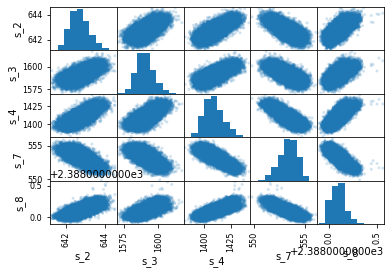

In [7]:
# Here are a small selection of useful looking signals, along with our taregt (RUL)
good_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8']
pd.plotting.scatter_matrix(train.loc[:,good_sensors], alpha=0.2)
plt.show()

As we discussed last week, we can gate the RUL during training if we "don't care about it above a threshold".
Consider histograms later in this script to understand why

In [8]:
train = add_remaining_useful_life(train)
train = gate_the_RUL(train,cap=150)

train[index_names+['RUL']] # last thing in cell prints out

,unit_number,time_cycles,RUL
0,1,1,150
1,1,2,150
2,1,3,150
3,1,4,150
4,1,5,150
...,...,...,...
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1


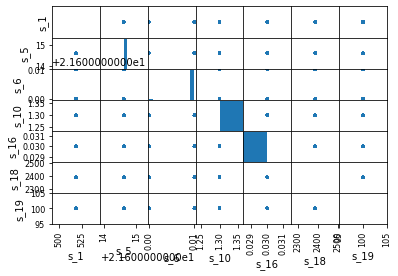

In [9]:
# these seem not worth keeping
import warnings
warnings.filterwarnings("ignore")
# drop_sensors = ['s_1','s_5','s_16','s_18','s_19'] # as per last week..
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19'] # new bad signals noted. 

pd.plotting.scatter_matrix(train.loc[:,drop_sensors])
plt.show()

In [10]:
# this time let's keep the cycles (normalised) showing current engine life
drop_labels = setting_names+drop_sensors # ['unit_number'] was index_names
 # last time we dropped ['unit_number'] here, now further below

In [11]:
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

In [12]:
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

In [13]:
X_test

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,2,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,3,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,4,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,5,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606
96,97,134,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953
97,98,121,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608
98,99,97,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391,38.95,23.3595


In [14]:

# in matlab this is called movmean()
#X_train = X_train.groupby('unit_number').rolling(20,min_periods=1).sum()
## X_test = X_test.groupby('unit_number').rolling(20,min_periods=1).sum() # train only
drop_labels = ['unit_number']
X_train = X_train.drop(drop_labels, axis=1)
X_test = X_test.drop(drop_labels, axis=1)


In [15]:
def zscore(X_train,X_test):
    # zero-centered normalise (standardise or zscore)
    mu = np.mean(X_train,axis=0)
    sig = np.std(X_train,axis=0)
    X_train = (X_train - mu) / sig
    X_test = (X_test - mu) / sig
    return X_train, X_test

In [16]:
# zero-centered normalise (standardise or zscore)
X_train, X_test = zscore(X_train,X_test)

img_rows, img_cols = 1, 15
input_shape = (img_rows, img_cols, 1)

In [17]:
n = len(X_train)
r = np.random.permutation(n) # randperm
# shuffle
X_train = X_train.iloc[r,:] # pandas df - tables: MATLAB style indexes
y_train = y_train.iloc[r] # capital letter for matrix (array), lower case column

# pandas .iloc .loc

splt = int(np.floor(n * 0.8))
X_val = X_train.iloc[splt:,:]
X_train_splt = X_train.iloc[1:splt,:] # to distinguish full X_train without holdout validation
print(len(X_train_splt))
print(len(X_val))

y_val = y_train.iloc[splt:]
y_train_splt = y_train.iloc[1:splt]
print(np.shape(y_train_splt))
print(np.shape(y_val))

16503
4127
(16503,)
(4127,)


In [18]:
X_train = X_train.values.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.values.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.values.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

In [19]:
# model = tf.keras.models.Sequential() # this time use 'functional API'

In [20]:
X_train.shape

(20631, 1, 15, 1)

In [21]:
inputs = tf.keras.Input(shape=input_shape, name="img")
x = tf.keras.layers.Conv2D(32, kernel_size=(1,3),)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(1,3), activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x) # shapde difference?
block_1_output = tf.keras.layers.Activation("relu")(x)
# block_1_output = tf.keras.layers.MaxPooling2D((1,3))(x) # remove? shape difference

x = tf.keras.layers.Conv2D(64, kernel_size=(1,3), padding="same")(block_1_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(1,3), padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
block_2_output = tf.keras.layers.add([x, block_1_output])

x = tf.keras.layers.Conv2D(64, kernel_size=(1,3), padding="same")(block_2_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(1,3), activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
block_3_output = tf.keras.layers.add([x, block_2_output])

x = tf.keras.layers.Conv2D(128, kernel_size=(1,3))(block_3_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs, name="1D_resnet")
model.summary()

Model: "1D_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 1, 15, 1)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 13, 32)    128         ['img[0][0]']                    
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 13, 32)   128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1, 13, 32)    0           ['batch_normalization[0][

In [22]:
# import pydot
# import graphviz
# tf.keras.utils.plot_model(model, "1d_NASA_resnet.png", show_shapes=True)

In the next section we define a custom metric, we manually split and shuffle data

In [23]:
import keras.backend as K # this will let us easily view rmse during training
def root_mean_squared_error(y_true, y_pred):
    # root_mean_squared_error as metric in compile
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 



In [24]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mae'])
# note using root_mean_squared_error here can cause issue copying model later without config set, using grid search.
# what if we used mae for loss..

In [25]:
# note we could have said validation_split,0.2. We can set shuffle here too... shuffle=True,
history = model.fit(X_train, y_train ,batch_size = 128, epochs = 30,verbose=1,
                   callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                                                     verbose=0, mode='min')],
                  validation_split=0.2)


Epoch 1/30
129/129 [==============================] - 10s 31ms/step - loss: 10229.2900 - mean_squared_error: 10229.2900 - mae: 91.0465 - val_loss: 10582.2480 - val_mean_squared_error: 10582.2480 - val_mae: 91.3496
Epoch 2/30
129/129 [==============================] - 3s 26ms/step - loss: 7901.9155 - mean_squared_error: 7901.9155 - mae: 79.9136 - val_loss: 7189.2173 - val_mean_squared_error: 7189.2173 - val_mae: 76.2904
Epoch 3/30
129/129 [==============================] - 3s 26ms/step - loss: 4890.5142 - mean_squared_error: 4890.5142 - mae: 62.2755 - val_loss: 3273.2703 - val_mean_squared_error: 3273.2703 - val_mae: 50.2162
Epoch 4/30
129/129 [==============================] - 3s 26ms/step - loss: 2236.2764 - mean_squared_error: 2236.2764 - mae: 40.5642 - val_loss: 1250.9163 - val_mean_squared_error: 1250.9163 - val_mae: 29.1443
Epoch 5/30
129/129 [==============================] - 4s 29ms/step - loss: 876.9050 - mean_squared_error: 876.9050 - mae: 23.9341 - val_loss: 689.1089 - val_me

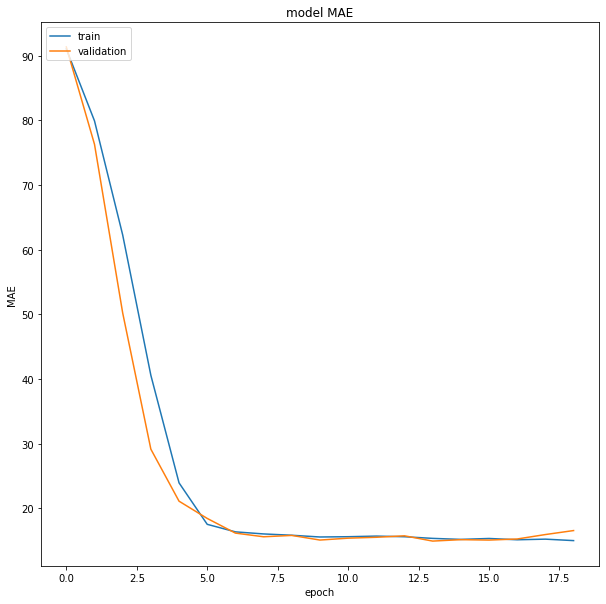

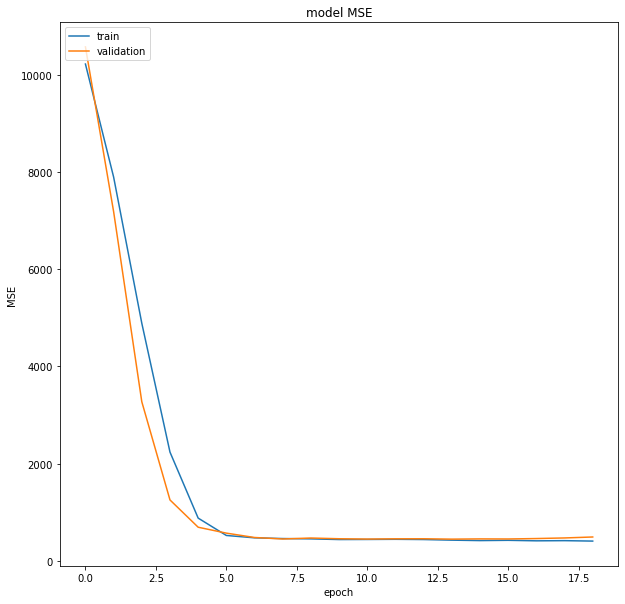

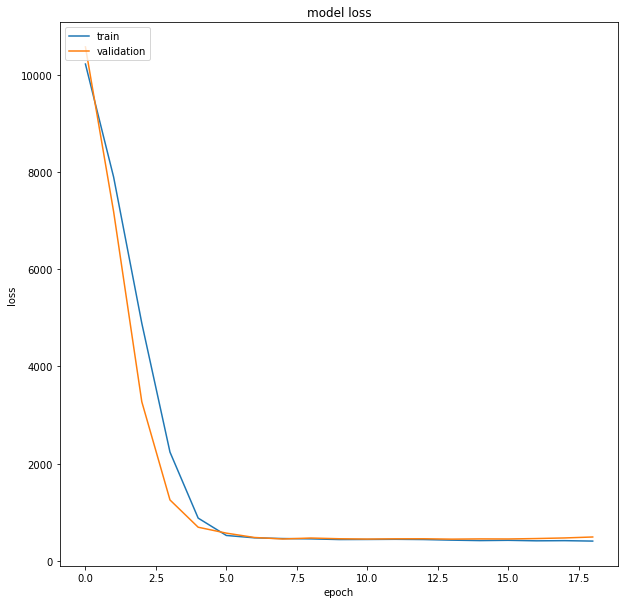

In [26]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_rmse.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left') 
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [27]:
model_pred = model.predict(X_test)

4/4 [==============================] - 0s 5ms/step


In [28]:
from sklearn.metrics import r2_score

In [29]:
print(np.shape(model_pred))
print(np.shape(y_test))

model_pred = np.squeeze(model_pred)
r2_score(y_test,model_pred)

(100, 1)
(100, 1)


0.781343097863224

In [30]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y_test,model_pred))
print("RMSE: ", RMSE)

RMSE:  19.431725531464608


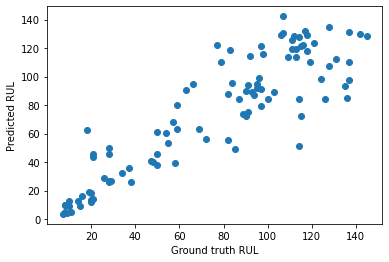

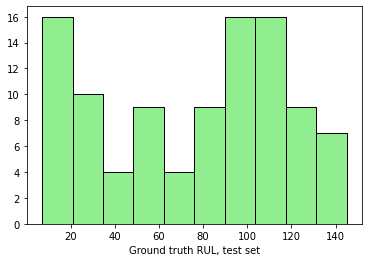

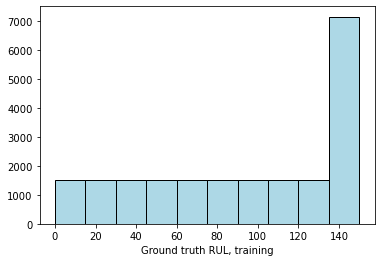

In [31]:
plt.scatter(y_test,model_pred)
plt.xlabel("Ground truth RUL")
plt.ylabel("Predicted RUL")
plt.show()

plt.hist(y_test, color = "lightgreen", ec="black")
plt.xlabel("Ground truth RUL, test set")
plt.show()

plt.hist(y_train, color = "lightblue", ec="black")
plt.xlabel("Ground truth RUL, training")
plt.show()

Here we say BayesOpt doesn't have 'validation_split' so we need to manually seperate the dat as we did for dense model

In [32]:
# Create the keras tuner model.
class MyHyperModel(HyperModel):
    
    def build(self, hp):
        inputs = tf.keras.Input(shape=input_shape, name="img")
        FILTS = hp.Int('num_kernel_filters', 3, 7)
        FILTS = 2 ** FILTS # powers of 2, so 8 to 128 in conv 1
        inputs = tf.keras.Input(shape=input_shape, name="img")
        x = tf.keras.layers.Conv2D(FILTS, kernel_size=(1,3),)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2D(FILTS*2, kernel_size=(1,3), activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x) # shapde difference?
        block_1_output = tf.keras.layers.Activation("relu")(x)
        # block_1_output = tf.keras.layers.MaxPooling2D((1,3))(x) # remove? shape difference

        x = tf.keras.layers.Conv2D(FILTS*2, kernel_size=(1,3), padding="same")(block_1_output)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2D(FILTS*2, kernel_size=(1,3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        block_2_output = tf.keras.layers.add([x, block_1_output])

        x = tf.keras.layers.Conv2D(FILTS*2, kernel_size=(1,3), padding="same")(block_2_output)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2D(FILTS*2, kernel_size=(1,3), activation="relu", padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        block_3_output = tf.keras.layers.add([x, block_2_output])

        x = tf.keras.layers.Conv2D(FILTS*4, kernel_size=(1,3))(block_3_output)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)

        x = tf.keras.layers.Flatten()(x) 
        
        for i in range(hp.Int('num_layers', 1, 3)):
            x = tf.keras.layers.Dense(128, activation="relu")(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            x = tf.keras.layers.Dropout(0.2)(x)
        
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs, outputs, name="1D_resnet")
        model.summary()

                
        model.compile(
            optimizer=hp.Choice('optimizer', values= ['Adam', 'Adadelta', 'Adamax']),
            loss='mean_squared_error',
            metrics=['mean_squared_error', 'mae'])
        return model


hypermodel = MyHyperModel()

In [33]:


tuner = BayesianOptimization(
    hypermodel,
    objective=Objective('val_loss', direction="min"),
    num_initial_points=50,
    max_trials=15,
    directory='./',
    project_name='NASA')

tuner.search(X_train, y_train,
             epochs=10, validation_data=(X_val, y_val))


Trial 15 Complete [00h 00m 33s]
val_loss: 409.50555419921875

Best val_loss So Far: 409.50555419921875
Total elapsed time: 00h 14m 33s
INFO:tensorflow:Oracle triggered exit


In [34]:
best_model = tuner.get_best_models()[0]

model_pred = best_model.predict(X_test)

Model: "1D_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 1, 15, 1)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 13, 16)    64          ['img[0][0]']                    
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 13, 16)   64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1, 13, 16)    0           ['batch_normalization[0][

In [35]:
r2_score(y_test,model_pred)

0.7880669039169093

In [36]:
RMSE = np.sqrt(mean_squared_error(y_test,model_pred))
print("RMSE: ", RMSE)

RMSE:  19.130625208282357


This next section may be easier to view in a new window, or see image noted in powerpoint.
It shows why we removed certain signals

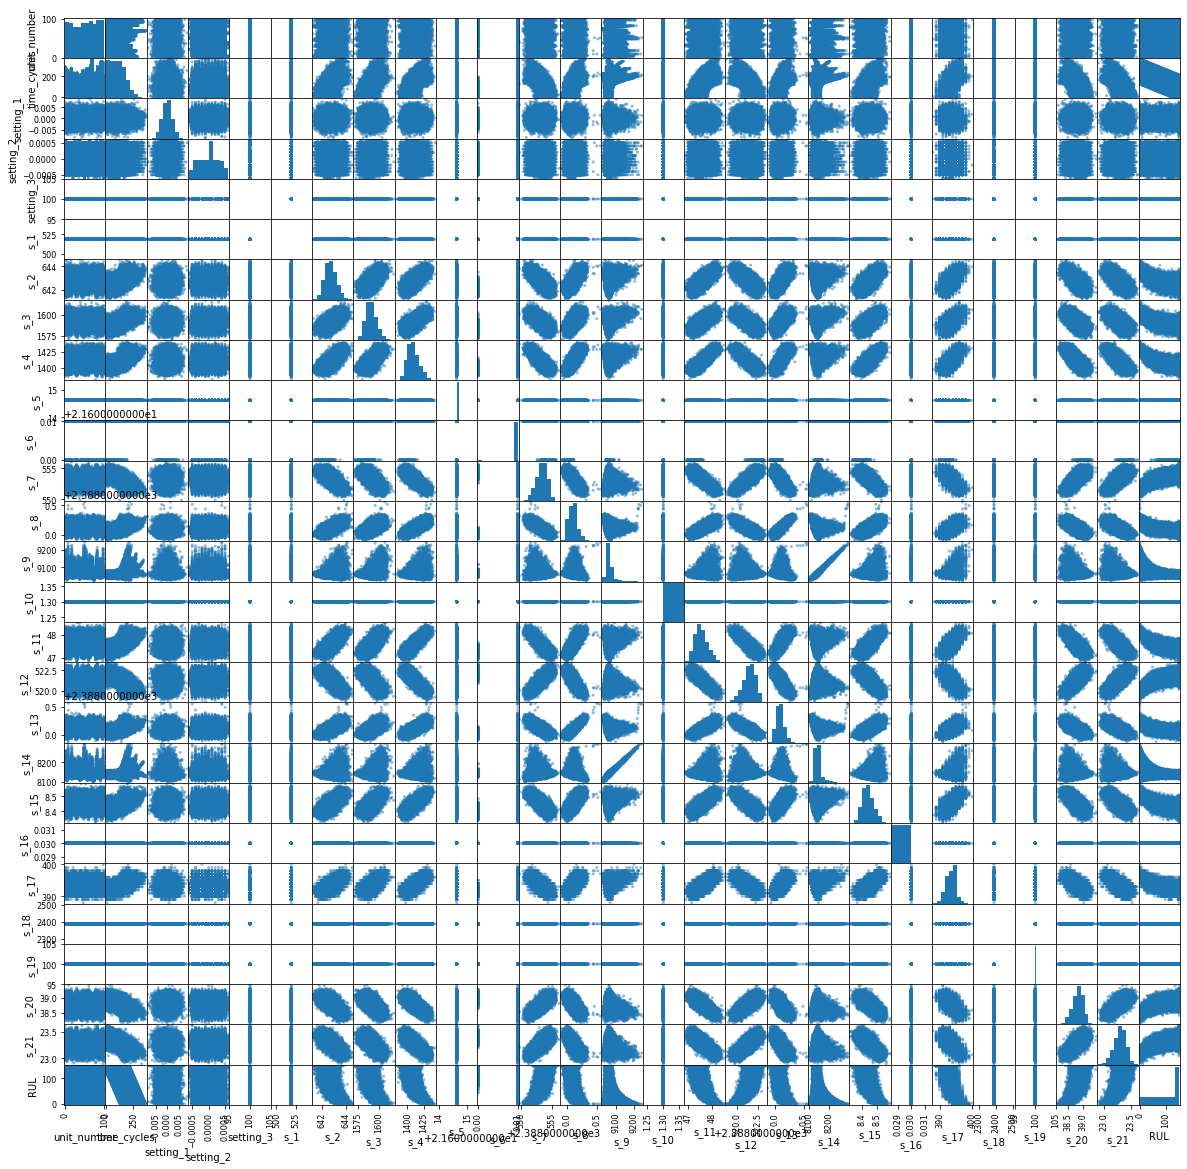

In [37]:
pd.plotting.scatter_matrix(train,figsize=[20,20])
plt.show()

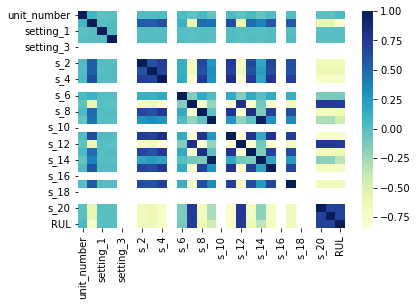

In [38]:
ax = sns.heatmap(train.corr(), cmap="YlGnBu")

In [39]:
2**8

256